In [2]:
import tensorflow as tf
import keras
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
from keras.layers import Conv2D, MaxPooling2D, Activation, UpSampling2D
from keras.datasets import mnist
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import TensorBoard, EarlyStopping

In [4]:
class Parameters():
    def __init__(self, img_shape, optimiser, batch_size=128, number_classes=10, epochs=50, data_augmentation=False):
        self.batch_size = batch_size
        self.number_classes = number_classes
        self.epochs = epochs
        self.data_augmentation = data_augmentation
        self.img_shape = img_shape
        self.optimiser = optimiser

In [5]:
class Model():
    def __init__(self, params):
        self.params = params
        self.decoder = Sequential()
        
        self.decoder.add(Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=(1, 1, 100)))
        self.decoder.add(UpSampling2D((2,2)))
        self.decoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
        self.decoder.add(UpSampling2D((2,2)))
        self.decoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
        self.decoder.add(UpSampling2D((2,2)))
        self.decoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
        self.decoder.add(UpSampling2D((2,2)))
        self.decoder.add(Conv2D(16, (3, 3), activation='relu'))
        self.decoder.add(UpSampling2D((2,2)))
        self.decoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
        
    def compile(self, loss="binary_crossentropy", metrics=['accuracy']):
        self.decoder.compile(loss=loss, optimizer=self.params.optimiser, metrics=metrics)
        
    def fit(self, x_train, y_train, validation_data, shuffle=True, callbacks=[TensorBoard(log_dir='conv_autoencoder')], verbose=2):
        self.decoder.fit(x_train, y_train, epochs=self.params.epochs, batch_size=self.params.batch_size, 
                       shuffle=shuffle, validation_data=validation_data, callbacks=callbacks, verbose=verbose)

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))    # adapt this if using 'channels_first' image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [8]:
params = Parameters(img_shape=x_train.shape[1:], epochs=30,
                    optimiser=keras.optimizers.Adadelta(lr=0.5, rho=0.95, epsilon=None, decay=0.0))
es = EarlyStopping(monitor='val_loss')
m = Model(params)
m.compile()

Instructions for updating:
Colocations handled automatically by placer.


In [36]:
train_noise=[]
for i in range(x_train.shape[0]):
        train_noise.append(np.random.uniform(y_train[i]*100, (y_train[i]+1)*100, (1, 1, 100)))
        
train_noise = np.array(train_noise)

test_noise=[]
for i in range(x_test.shape[0]):
        test_noise.append(np.random.uniform(y_test[i]*100, (y_test[i]+1)*100, (1, 1, 100)))
        
test_noise = np.array(test_noise)


In [38]:
m.fit(train_noise, x_train, (test_noise, x_test), verbose=1, 
      callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 34s 575us/step - loss: 0.2745 - acc: 0.8027 - val_loss: 0.2659 - val_acc: 0.8015
Epoch 2/30
60000/60000 [==============================] - 32s 537us/step - loss: 0.2622 - acc: 0.8027 - val_loss: 0.2582 - val_acc: 0.8008
Epoch 3/30
60000/60000 [==============================] - 30s 502us/step - loss: 0.2578 - acc: 0.8017 - val_loss: 0.2541 - val_acc: 0.7982
Epoch 4/30
60000/60000 [==============================] - 34s 569us/step - loss: 0.2523 - acc: 0.7999 - val_loss: 0.2487 - val_acc: 0.8011
Epoch 5/30
60000/60000 [==============================] - 36s 601us/step - loss: 0.2487 - acc: 0.7981 - val_loss: 0.2448 - val_acc: 0.7966
Epoch 6/30
60000/60000 [==============================] - 35s 588us/step - loss: 0.2467 - acc: 0.7972 - val_loss: 0.2439 - val_acc: 0.7979
Epoch 7/30
60000/60000 [==============================] - 42s 697us/step - loss: 0.2456 - acc: 0.7973 - val_loss: 0.

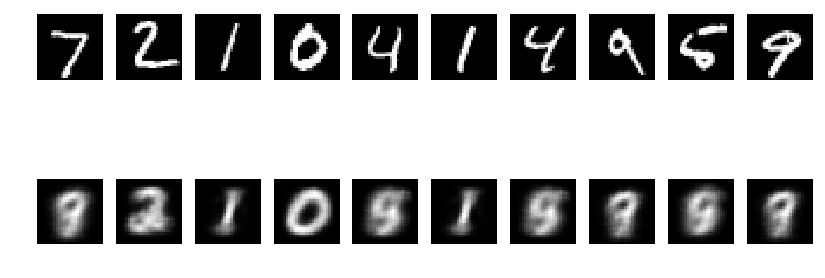

In [39]:
n = 10
decoded_imgs = m.decoder.predict(test_noise)
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

plt.show()